In [2]:
import pandas as pd
import numpy as np

# 1. Load data
base_dir = r'C:\Users\lgjel\Desktop\MITB Course\7. Apr 2025 Term\CS610 Applied Machine Learning_G1\SIA Project'
df = pd.read_csv(f"{base_dir}/Singapore_airlines_reviews.csv")

In [3]:
df

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0
...,...,...,...,...,...,...,...
9995,2018-08-06T03:48:21-04:00,Desktop,5,review,First part done with Singapore Airlines - acce...,"Flew to NZ 1st half Singapore Airlines, 2nd ha...",1
9996,2018-08-05T22:50:29-04:00,Mobile,5,review,And again a great Flight with Singapore Air. G...,Best Airline,1
9997,2018-08-05T22:47:06-04:00,Desktop,5,review,"We flew business class from Frankfurt, via Sin...",Superb service on Singapore Airlines,1
9998,2018-08-05T20:32:03-04:00,Desktop,4,review,"As always, the A380 aircraft was spotlessly pr...",A Comfortable Fiight Spoiled by lack of adequa...,2


In [4]:
# 2. Backup raw column
df['published_date_raw'] = df['published_date']

# 3. First parsing attempt
df['published_date'] = pd.to_datetime(
    df['published_date_raw'],
    errors='coerce',
    infer_datetime_format=True,
    utc=True
)

n_missing = df['published_date'].isna().sum()
print(f"First pass: {n_missing} records failed to parse.")

# 5. Inspect a handful of the offending raw strings
print("Examples of unparsed dates:")
print(df.loc[df['published_date'].isna(), 'published_date_raw']
        .drop_duplicates()
        .head(20)
        .tolist())

print("\nAfter any second-pass attempts:")
print(df['published_date'].dtypes, "|  Missing:", df['published_date'].isna().sum())


First pass: 0 records failed to parse.
Examples of unparsed dates:
[]

After any second-pass attempts:
datetime64[ns, UTC] |  Missing: 0


C:\Users\lgjel\AppData\Local\Temp\ipykernel_14032\866795156.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['published_date'] = pd.to_datetime(


In [5]:
print("Data types after conversion:")
print(df.dtypes)

Data types after conversion:
published_date        datetime64[ns, UTC]
published_platform                 object
rating                              int64
type                               object
text                               object
title                              object
helpful_votes                       int64
published_date_raw                 object
dtype: object


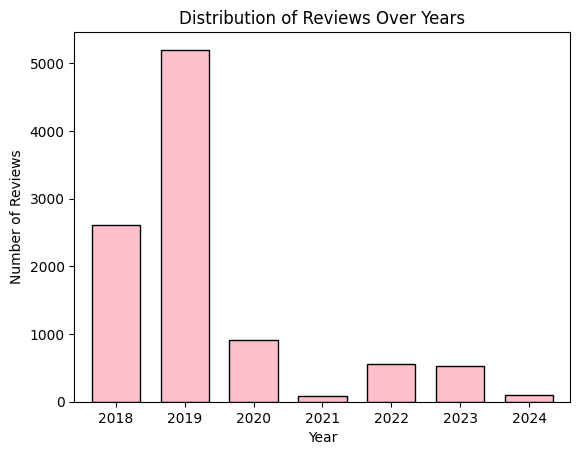

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

year_counts = (   # extract year, drop NaT, cast to int
    df['published_date']
      .dt.year
      .dropna()
      .astype(int)
      .value_counts()
      .sort_index()
)

# plot with integer labels
year_counts.plot(kind='bar', width=0.7, color='pink', edgecolor='black')
plt.title('Distribution of Reviews Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

In [7]:
null_text = df['text'].isnull().sum()
duplicate_text = df.duplicated(subset='text').sum()
df['TextLength'] = df['text'].str.len()
comment_length_stats = df['TextLength'].describe()

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# If you haven’t already, download these resources once:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

ENGLISH_STOPS = set(stopwords.words('english'))
DOMAIN_STOPS = {
    'singapore', 'airline', 'airlines', 'sia', 'flight', 'plane', 'aircraft',
    'passenger', 'trip', 'journey', 'customer', 
    'experience', 'review', 'checkin', 'air', 'first', 'return', 
    'cabin','next', 'better', 'room', 'two', 'attendant', 'served', 'offered', 
    'asked', 'first', 'disappointed', 'fly', 'year', 'flying', 'flown', 'excellent', 'airport'
}

# 3. Extra high-frequency filler words
EXTRA_STOPS = {
    'used', 'use', 'get', 'got', 'make', 'one', 'would', 'really',
    'also', 'even', 'since', 'never', 'time', 'thing', 'things', 'way',
    'going', 'gonna', 'gotta', 'need', 'take', 'want', 'see', 'look', 'much', 
    'good', 'bad', 'great', 'best', 'worst', 'like', 'love', 'hate',
    'feel', 'felt', 'think', 'thought', 'say', 'said', 'tell', 'told',
    'make', 'made', 'do', 'did', 'does', 'doing', 'can', 'could',
    'will', 'would', 'shall', 'should', 'may', 'might', 'must', 'is',
    'are', 'was', 'were', 'be', 'been', 'being', 'has', 'have', 'had',
    'having', 'it', 'its', 'they', 'them', 'their', 'theirs', 'he',
    'him', 'his', 'she', 'her', 'hers', 'we', 'us', 'our', 'ours',
    'you', 'your', 'yours', 'me', 'my', 'mine', 'this', 'that', 'these',
    'those', 'there', 'here', 'where', 'when', 'why', 'how', 'what',
    'who', 'whom', 'which', 'while', 'although', 'if', 'unless', 'until',
    'because', 'so', 'but', 'and', 'or', 'nor', 'yet', 'for', 'with',
    'about', 'as', 'at', 'by', 'from', 'in', 'into', 'of', 'on', 'to',
    'up', 'down', 'over', 'under', 'between', 'among', 'through', 'across',
    'after', 'before', 'during', 'without', 'within', 'along', 'around',
    'against', 'beside', 'beyond', 'despite', 'except', 'inside', 'outside',
    'past', 'since', 'till', 'until', 'via', 'upon', 'about', 'above', 'hour', 
    'back'

}

# Combine once
STOPWORDS = ENGLISH_STOPS.union(DOMAIN_STOPS, EXTRA_STOPS)

# Reusable NLP tools
LEMMATIZER = WordNetLemmatizer()
TOKENIZER   = RegexpTokenizer(r'\w+')

def preprocess_text(text: str) -> list[str]:
    """
    Lowercase, strip URLs/HTML, remove punctuation,
    tokenize, drop stopwords & short tokens, then lemmatize.
    Returns a list of clean tokens.
    """
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = TOKENIZER.tokenize(text)
    tokens = [
        LEMMATIZER.lemmatize(tok)
        for tok in tokens
        if tok not in STOPWORDS and len(tok) > 2
    ]
    return tokens

In [9]:
processed_texts = df['text'].map(preprocess_text).tolist()

In [10]:
# Detect bigrams 
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora
bigram = Phrases(processed_texts, min_count=20, threshold=10)
bigram_mod = Phraser(bigram)
texts_with_bigrams = [bigram_mod[doc] for doc in processed_texts]

In [11]:
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.2)
corpus = [dictionary.doc2bow(doc) for doc in texts_with_bigrams]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
docs = [" ".join(doc) for doc in texts_with_bigrams]

vectorizer = CountVectorizer(
    min_df=5,    # ignore tokens that appear in fewer than 5 docs
    max_df=0.2,  # ignore tokens in more than 20% of docs
    token_pattern=r'\S+'  # since we've already tokenized, split on whitespace
)
X1 = vectorizer.fit_transform(docs)

In [13]:
X1.shape

(10000, 5246)

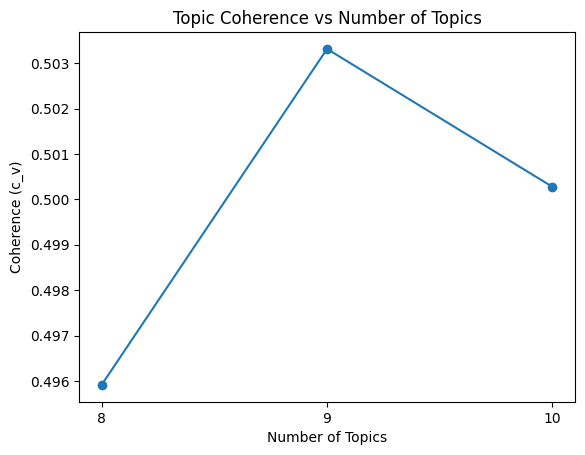

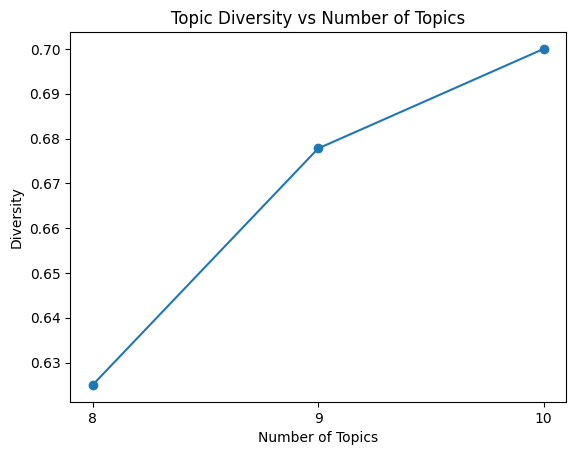

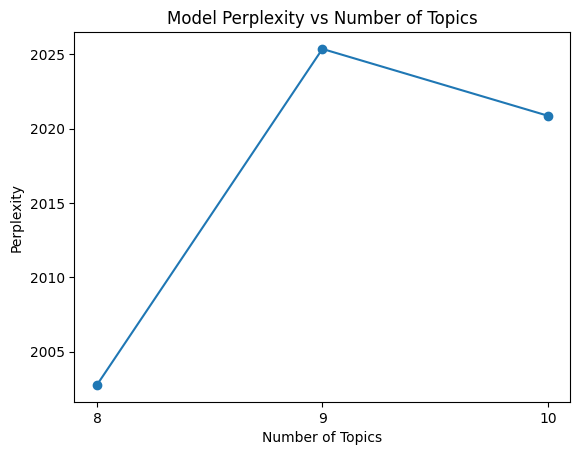

In [33]:
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# -- Ensure 'texts_with_bigrams', 'vectorizer', and 'X1' are defined in your session --
# 1. Prepare Gensim dictionary on tokenized texts
dictionary = Dictionary(texts_with_bigrams)

# 2. Define topic counts to evaluate
topic_numbers = [8, 9, 10]

# 3. Compute metrics for each k
results = []
for k in topic_numbers:
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(X1)
    
    # Top words extraction
    TOP_N = 10
    feature_names = vectorizer.get_feature_names_out()
    topics = [
        [feature_names[i] for i in comp.argsort()[-TOP_N:][::-1]]
        for comp in lda.components_
    ]
    
    # Coherence (c_v)
    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts_with_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    
    # Diversity
    all_top_words = [w for topic in topics for w in topic]
    diversity_score = len(set(all_top_words)) / (k * TOP_N)
    
    # Perplexity
    perplexity_score = lda.perplexity(X1)
    
    results.append({
        'n_topics': k,
        'coherence_c_v': coherence_score,
        'diversity': diversity_score,
        'perplexity': perplexity_score
    })

# 4. Create DataFrame
results_df = pd.DataFrame(results)

# 5. Elbow charts for each metric

# Coherence vs k
plt.figure()
plt.plot(results_df['n_topics'], results_df['coherence_c_v'], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence (c_v)')
plt.title('Topic Coherence vs Number of Topics')
plt.xticks(topic_numbers)
plt.show()

# Diversity vs k
plt.figure()
plt.plot(results_df['n_topics'], results_df['diversity'], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Diversity')
plt.title('Topic Diversity vs Number of Topics')
plt.xticks(topic_numbers)
plt.show()

# Perplexity vs k
plt.figure()
plt.plot(results_df['n_topics'], results_df['perplexity'], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Model Perplexity vs Number of Topics')
plt.xticks(topic_numbers)
plt.show()


Topic discovery

In [19]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

lda_10_model = LatentDirichletAllocation(
    n_components=9,
    topic_word_prior=0.1,
    learning_method='batch',
    max_iter=10,
    random_state=42
)
lda_10_model.fit(X1)


LatentDirichletAllocation(n_components=9, random_state=42, topic_word_prior=0.1)

In [20]:
import pickle
with open(f"{base_dir}/lda_10_model.pkl", "wb") as f:
    pickle.dump(lda_10_model, f)

In [21]:
def display_topics(model, feature_names, no_top_words): #display top words for each topic
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda_10_model, feature_names, 10)

Topic #0:
always economy entertainment premium_economy choice leg flight business_class flew class
Topic #1:
always passenger helpful well thank care smile check friendly travel
Topic #2:
hour meal flight sin long standard sydney leg poor route
Topic #3:
ticket booking day booked change call flight refund email travel
Topic #4:
passenger business_class meal economy_class menu well class toilet screen lavatory
Topic #5:
hour luggage bag day minute arrived flight hotel baggage check
Topic #6:
meal flight always well drink kid request friendly nice flew
Topic #7:
meal economy premium_economy drink passenger water ask toilet poor row
Topic #8:
business_class lounge bed sleep new leg check boarding foot space


In [28]:
# 11. Assign Dominant Topic
doc_topic_dist = lda_10_model.transform(X1)
df['Dominant_Topic'] = doc_topic_dist.argmax(axis=1)

# Optional: Manually label topics (replace values after reviewing top words)
topic_labels = {
    0: "Cabin Class",
    1: "Service",
    2: "Routing",
    3: "Booking & Refund",
    4: "Cabin Facilities",
    5: "Baggage Handling & Delays",
    6: "Food & Beverage",
    7: "Cabin Service",
    8: "Business Class",

}

df['Topic_Label'] = df['Dominant_Topic'].map(topic_labels)


In [29]:
# 12. Sentiment Mapping
def map_sentiment(rating):
    if rating in [1, 2]: return 'Negative'
    elif rating == 3: return 'Neutral'
    else: return 'Positive'

df['Sentiment'] = df['rating'].apply(map_sentiment)

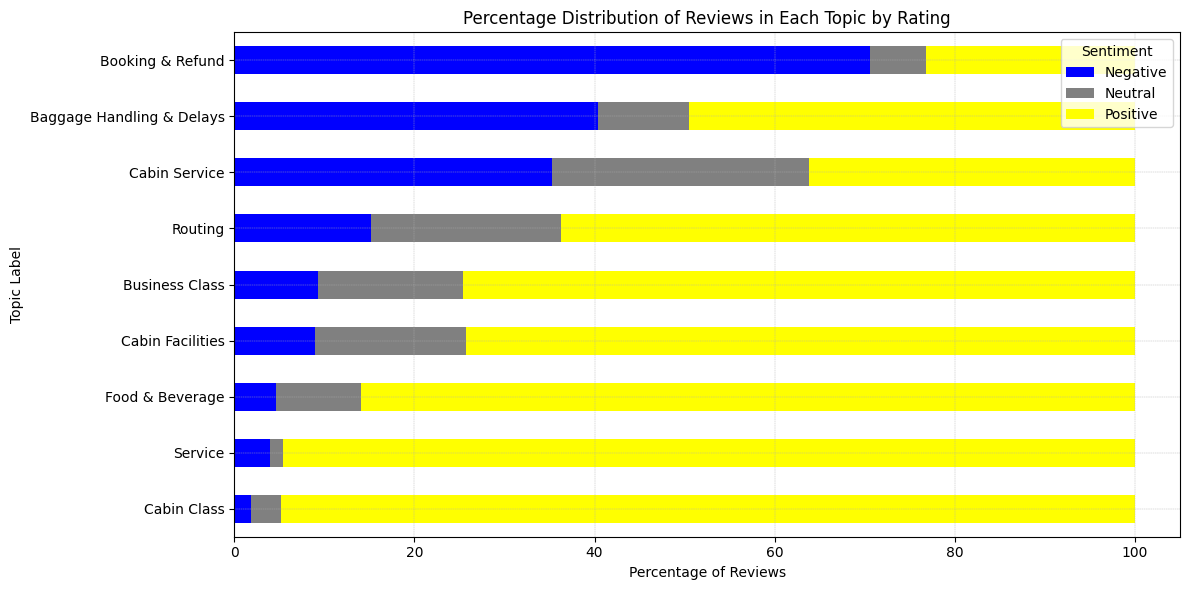

In [30]:
# 13. Plot Sentiment Distribution by Topic (in Percentage, Sorted by Negative Sentiment)
sent_table = df.groupby(['Topic_Label', 'Sentiment']).size().unstack(fill_value=0)
sent_table_percent = sent_table.div(sent_table.sum(axis=1), axis=0) * 100
# Sort by percentage of negative sentiment in descending order
sent_table_percent = sent_table_percent.sort_values(by='Negative', ascending=False)

plt.figure(figsize=(12, 6))
sent_table_percent.plot(kind='barh', stacked=True, ax=plt.gca(), color=['blue', 'gray', 'yellow'])
plt.title('Percentage Distribution of Reviews in Each Topic by Rating')
plt.xlabel('Percentage of Reviews')
plt.ylabel('Topic Label')
plt.legend(title="Sentiment", loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [32]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
# use the same tokenized texts you fed into LDA
texts = processed_texts  # List[List[str]]
# build a Gensim dictionary on those tokens
dictionary = Dictionary(texts)

# choose how many top words per topic you want to evaluate
TOP_N = 9
feature_names = vectorizer.get_feature_names_out()
topics = [
    [feature_names[i] for i in comp.argsort()[-TOP_N:][::-1]]
    for comp in lda_10_model.components_
]

coherence_model = CoherenceModel(
    topics=topics,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Topic Coherence (c_v): {coherence_score:.4f}")

all_top_words = [w for topic in topics for w in topic]
unique_words = set(all_top_words)
diversity_score = len(unique_words) / (len(topics) * TOP_N)
print(f"Topic Diversity: {diversity_score:.4f}")


Topic Coherence (c_v): 0.5202
Topic Diversity: 0.6790
